In [1]:
from itertools import cycle, islice

import flax
import jax
import jax.numpy as jnp
from matplotlib import pylab as plt
import numpy as onp
import sklearn
import sklearn.datasets
import tqdm

from continuous_net_jax.continuous_net import ContinuousClassifier
from continuous_net_jax.residual_modules import ShallowNet

In [2]:
jax.config.enable_omnistaging()

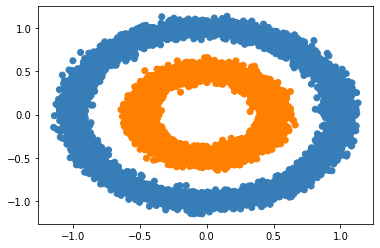

In [3]:
colors = onp.array(list(islice(cycle(
    ['#377eb8', '#ff7f00', '#4daf4a',
     '#f781bf', '#a65628', '#984ea3',
     '#999999', '#e41a1c', '#dede00']),
    int(max([1]) + 1))))
X,Y = sklearn.datasets.make_circles(
    n_samples=15000, factor=.5, noise=.05)
plt.scatter(X[:,0],X[:,1],color=colors[Y])

In [4]:
prng_key = jax.random.PRNGKey(0)
cnet_model = ContinuousClassifier(ode_dim=3, hidden_dim=1, n_basis=3)
ode_params = cnet_model.init(prng_key, jnp.ones((2,)))['params']

/usr/local/lib/python3.7/site-packages/jax/lib/xla_bridge.py:130: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')


In [5]:
@jax.vmap
def cross_entropy_loss(p, label):
  """Binary: label is 0 or 1, and p is a scalar probability."""
  return -(label)*jnp.log(p) - (1-label)*(jnp.log(1-p))


@jax.jit
def train_step(optimizer, X_batch, Y_batch):
    """One step of the optimizer, compiled."""
    def loss_fn(params):
        """Take the mean of BCE over the batch."""
        p_pred = cnet_model.apply({'params': params}, X_batch)
        loss = jnp.mean(cross_entropy_loss(p_pred, Y_batch))
        return loss
    loss, grad = jax.value_and_grad(loss_fn)(optimizer.target)
    optimizer = optimizer.apply_gradient(grad)
    return optimizer, loss


optimizer = flax.optim.Adam(learning_rate=0.001).create(
    ode_params)
n_train_steps = 10000  # 2*(X.shape[0]-1)
losses = onp.empty(n_train_steps)
for i in tqdm.tqdm(range(n_train_steps)):
    idcs = onp.random.choice(X.shape[0], 32)
    x0, y0 = X[idcs,:], Y[idcs]
    optimizer, loss_val = train_step(optimizer, x0, y0)
    losses[i] = loss_val

100%|██████████| 10000/10000 [00:22<00:00, 445.80it/s]


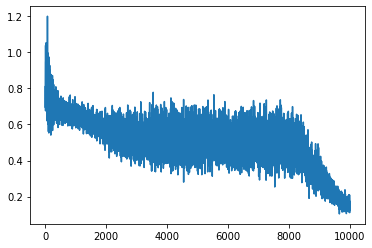

In [6]:
plt.plot(losses)

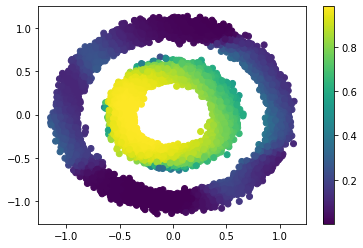

In [7]:
y_pred = cnet_model.apply({'params': optimizer.target}, X)
plt.scatter(X[:,1], X[:, 0], c=y_pred)
plt.colorbar()